In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/starter.ipynb.zip

Archive:  /content/drive/MyDrive/starter.ipynb.zip
  inflating: starter.ipynb           
  inflating: __MACOSX/._starter.ipynb  


In [ ]:
!unzip /content/drive/MyDrive/dev_phase.zip

Archive:  /content/drive/MyDrive/dev_phase.zip
   creating: subtask1/
   creating: subtask1/dev/
  inflating: subtask1/dev/nep.csv    
  inflating: subtask1/dev/ita.csv    
  inflating: subtask1/dev/pol.csv    
  inflating: subtask1/dev/rus.csv    
  inflating: subtask1/dev/tel.csv    
  inflating: subtask1/dev/hin.csv    
  inflating: subtask1/dev/hau.csv    
  inflating: subtask1/dev/pan.csv    
  inflating: subtask1/dev/ori.csv    
  inflating: subtask1/dev/spa.csv    
  inflating: subtask1/dev/deu.csv    
  inflating: subtask1/dev/fas.csv    
  inflating: subtask1/dev/arb.csv    
  inflating: subtask1/dev/ben.csv    
  inflating: subtask1/dev/amh.csv    
  inflating: subtask1/dev/khm.csv    
  inflating: subtask1/dev/tur.csv    
  inflating: subtask1/dev/zho.csv    
  inflating: subtask1/dev/eng.csv    
  inflating: subtask1/dev/swa.csv    
  inflating: subtask1/dev/urd.csv    
  inflating: subtask1/dev/mya.csv    
   creating: subtask1/train/
  inflating: subtask1/train/nep.csv  


# Subtask 1 - Polarization detection

In [ ]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.0+cpu


In [ ]:
import wandb

# # Disable wandb logging for this script
# wandb.init(mode="disabled")

## First language :english

### Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized



In [ ]:
# Load the training and validation data for subtask 1

train_initial = pd.read_csv('subtask1/train/eng.csv')
#val = pd.read_csv('subtask1/train/eng.csv')

train_initial.head()

,id,text,polarization
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0


Dev data

In [ ]:

test_for_website = pd.read_csv('subtask1/dev/eng.csv')

## Dataset

### Textual ANALYSIS

In [ ]:
# Extract texts and labels
texts = train_initial['text']
labels = train_initial['polarization']

In [ ]:
train_initial.head(20)

,id,text,polarization
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0
5,eng_bb7b41ffa6c56b52f8bbeb21a4c7aa77,"""Enemy of the people"" was a phrase coined and ...",0
6,eng_3a6672eb8e74090ad8884ee4f3343dc0,"""He also voiced support for Elon Musk, Tommy R...",0
7,eng_2c77bd1f661480f247fad599ac99bd17,"""If you disagree with imperialism, youre a sup...",0
8,eng_3b91189f79ee9b5423000bb60460491b,"""italian"" as a national identity is totally ov...",0
9,eng_c39ae8ec15297d3528d8c2a5dd7e2753,"""No to ethnic cleansing"". QudsDay QudsMainIssue",0


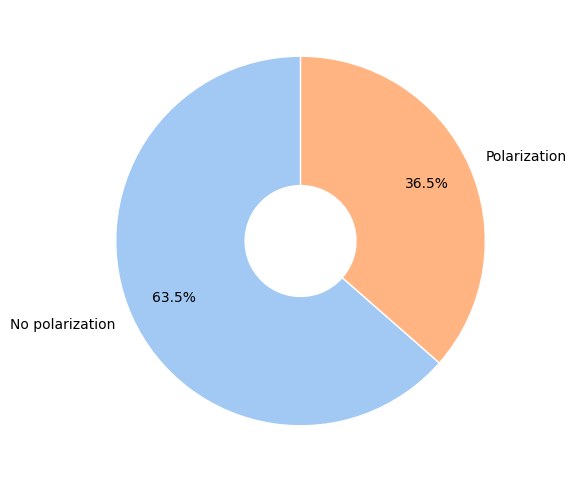

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

texts = train_initial['text']
labels = train_initial['polarization']


data_counts = labels.value_counts().rename({1: 'Polarization', 0: 'No polarization'})


plt.figure(figsize=(8, 6))
#plt.title('Polarization distribution')


plt.pie(data_counts,
        labels=data_counts.index,
        colors=sns.color_palette('pastel'),
        autopct='%.1f%%',
        startangle=90,
        pctdistance=0.75,
        wedgeprops={'width': 0.7, 'edgecolor': 'white'})
plt.savefig('subtask1_distribution_english.pdf')
plt.show()

        word_count   char_count
count  3222.000000  3222.000000
mean     12.261018    74.777778
std       8.019835    47.385309
min       4.000000    18.000000
25%       7.000000    46.000000
50%       9.000000    58.000000
75%      15.000000    89.750000
max      60.000000   299.000000

95th percentile (words): 27.0


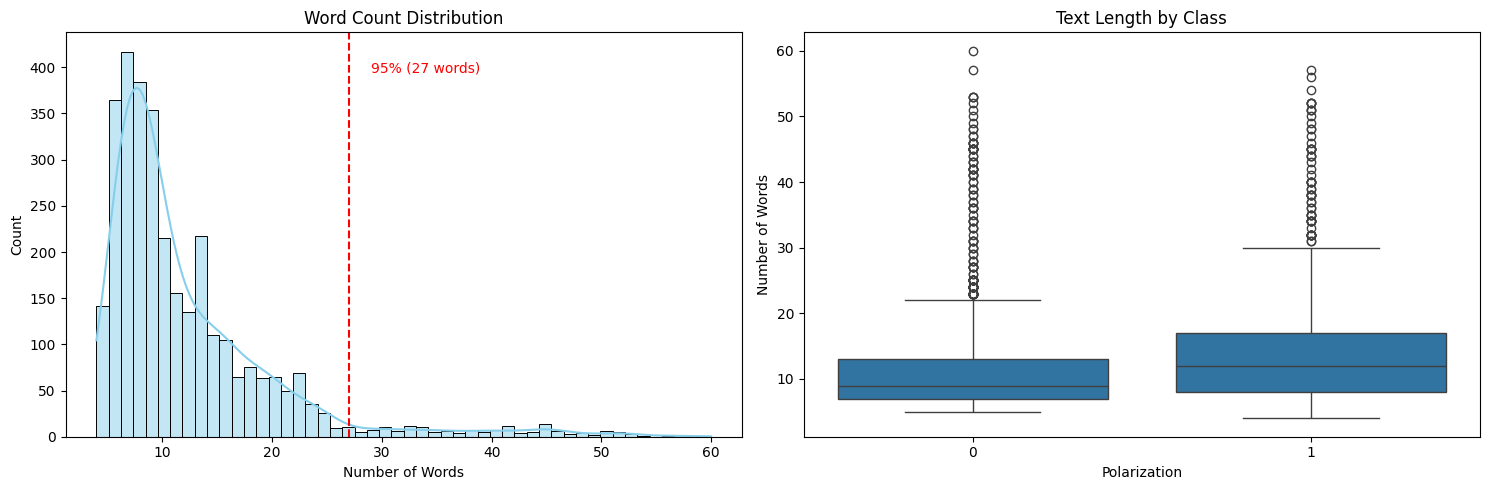

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_len = pd.DataFrame({'text': texts, 'label': labels})
df_len['word_count'] = df_len['text'].apply(lambda x: len(str(x).split()))
df_len['char_count'] = df_len['text'].apply(len)

print(df_len[['word_count', 'char_count']].describe())

p95_words = np.percentile(df_len['word_count'], 95)
print(f"\n95th percentile (words): {p95_words}")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_len['word_count'], bins=50, kde=True, ax=ax[0], color='skyblue')
ax[0].axvline(p95_words, color='red', linestyle='--')
ax[0].text(p95_words + 2, ax[0].get_ylim()[1]*0.9, f'95% ({int(p95_words)} words)', color='red')
ax[0].set_title('Word Count Distribution')
ax[0].set_xlabel('Number of Words')

sns.boxplot(x='label', y='word_count', data=df_len, ax=ax[1])
ax[1].set_title('Text Length by Class')
ax[1].set_xlabel('Polarization')
ax[1].set_ylabel('Number of Words')

plt.tight_layout()
plt.savefig('subtask1_worldcount_boxplot_distribution_english.pdf')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_top_n_words(corpus, n=None, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=['Term', 'Frequency'])


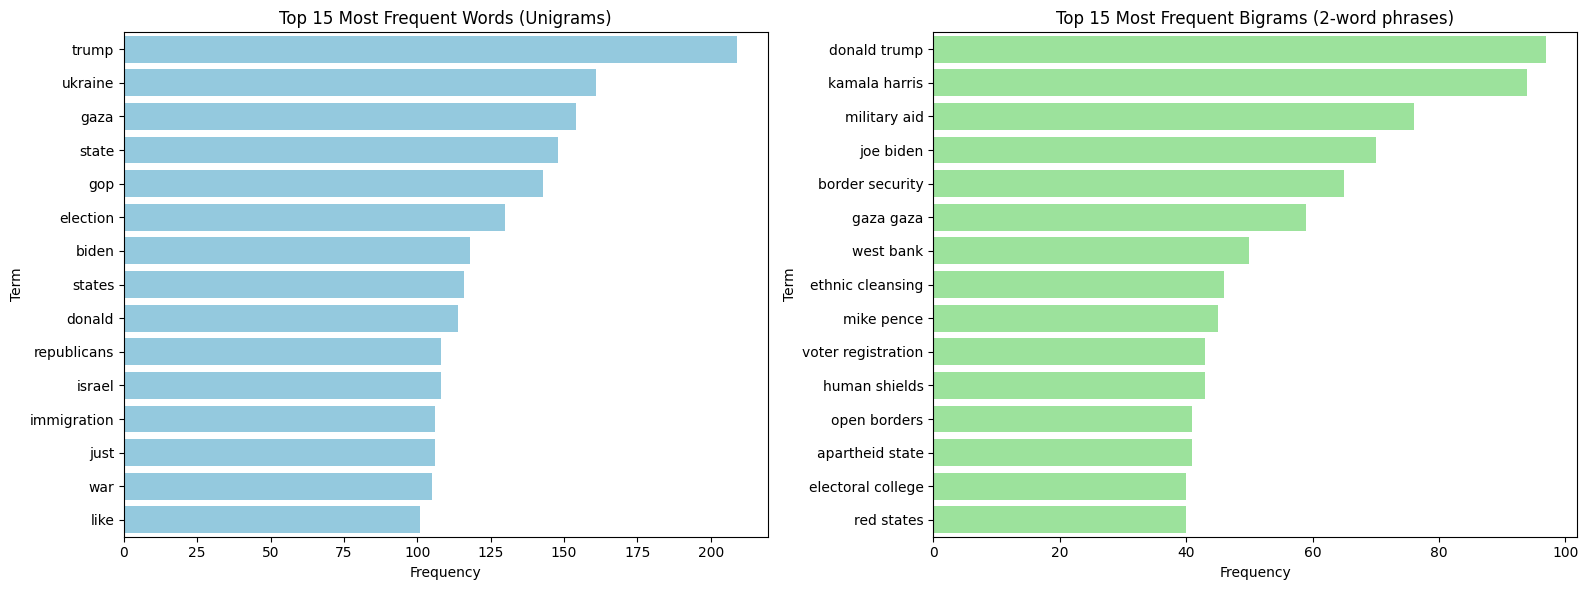

In [ ]:

df_unigrams = get_top_n_words(texts, n=15, ngram_range=(1,1))
df_bigrams = get_top_n_words(texts, n=15, ngram_range=(2,2))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x='Frequency', y='Term', data=df_unigrams, ax=ax[0], color='skyblue')
ax[0].set_title('Top 15 Most Frequent Words (Unigrams)')

sns.barplot(x='Frequency', y='Term', data=df_bigrams, ax=ax[1], color='lightgreen')
ax[1].set_title('Top 15 Most Frequent Bigrams (2-word phrases)')

plt.tight_layout()
plt.show()

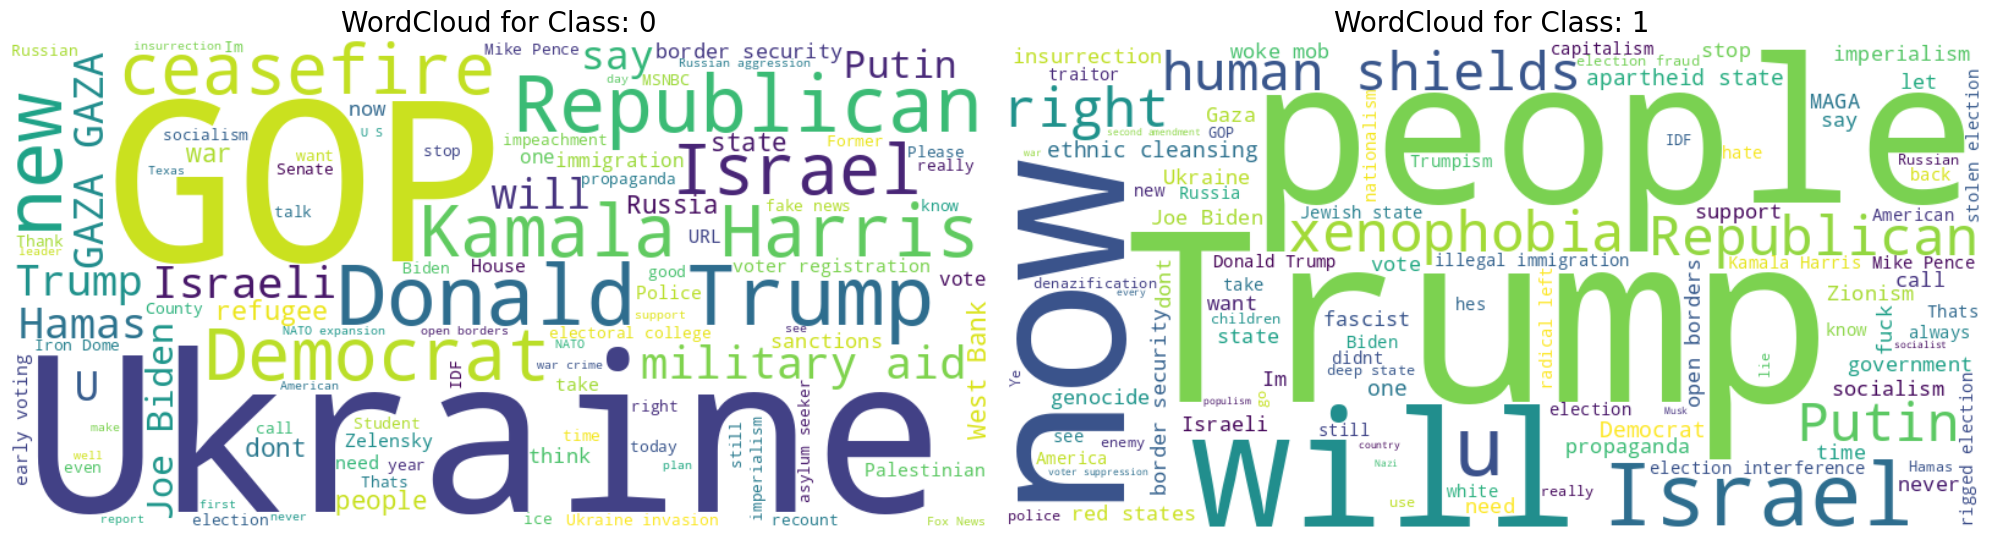

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer



unique_labels = labels.unique()


fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 10))


for i, label in enumerate(unique_labels):

    subset_text = texts[labels == label]

    text_combined = " ".join(subset_text.astype(str))


    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   max_words=100,
                   stopwords=STOPWORDS).generate(text_combined)

    # Plotting
    ax = axes[i] if len(unique_labels) > 1 else axes
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"WordCloud for Class: {label}", fontsize=20)

plt.tight_layout()
plt.show()

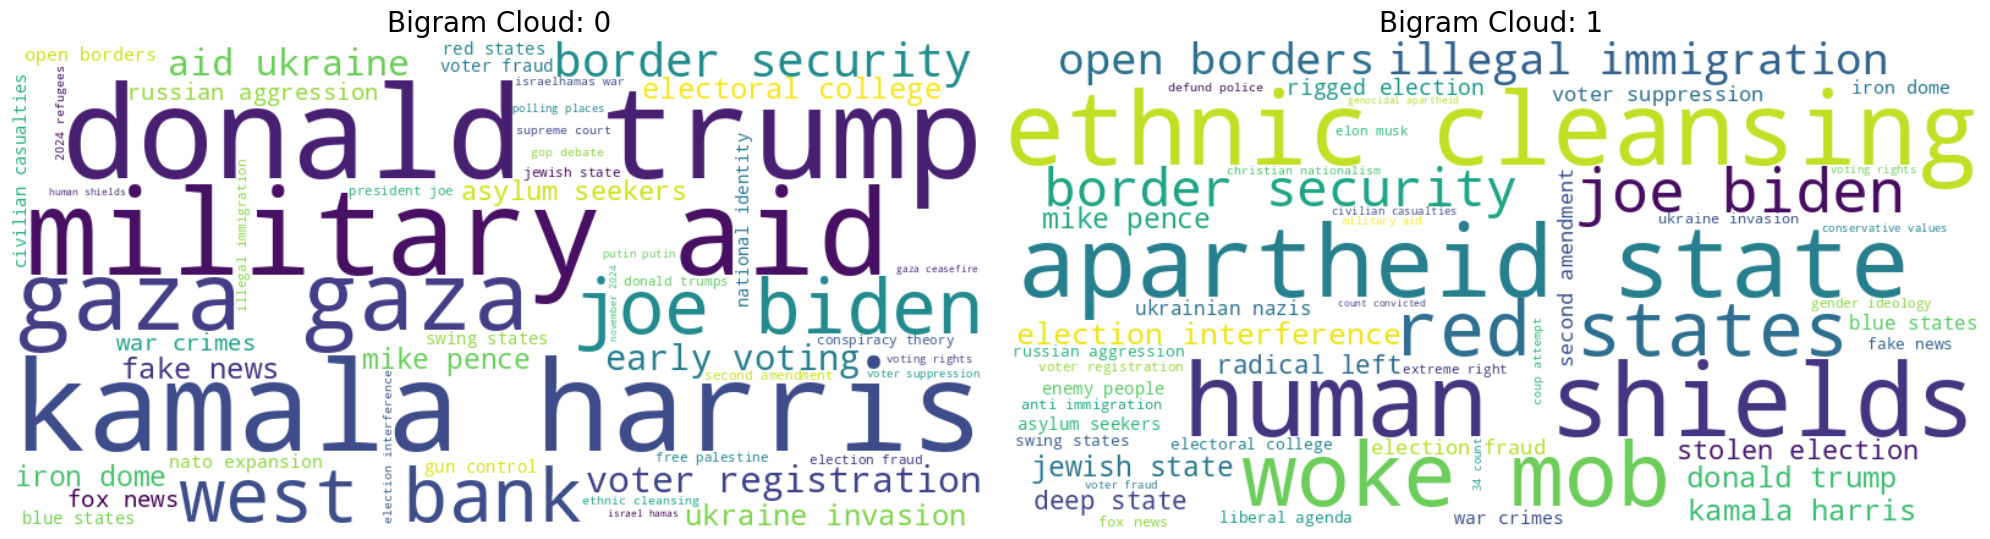

In [ ]:

unique_labels = labels.unique()
fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 10))


for i, label in enumerate(unique_labels):

    subset_text = texts[labels == label]


    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=50)
    matrix = vectorizer.fit_transform(subset_text.astype(str))


    frequencies = sum(matrix).toarray()[0]
    bg_freq = pd.DataFrame(frequencies, index=vectorizer.get_feature_names_out(), columns=['frequency'])

    freq_dict = bg_freq['frequency'].to_dict()

    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

    ax = axes[i] if len(unique_labels) > 1 else axes
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Bigram Cloud: {label}", fontsize=20)
plt.savefig('lexical_polarization_signalisation_substack1_english.pdf')
plt.tight_layout()
plt.show()

In [ ]:
# Extract texts and labels
texts = train_initial['text'].tolist()
labels = train_initial['polarization'].tolist()

In [ ]:
# Extract texts and labels
texts = train_initial['text'].tolist()
labels = train_initial['polarization'].tolist()


In [ ]:

texts = train_initial['text'].astype(str).tolist()
labels_raw = train_initial['polarization'].tolist()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(labels_raw)
print("Label classes (encoder):", le.classes_)


Label classes (encoder): [0 1]


 ### Classical Machine Learning (Baseline)

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split # Import train_test_split

# Re-split data to ensure X_train and X_val are lists of strings
# Assuming 'texts' and 'y' are available from previous executed cells.
test_size = 0.2         # fraction for test set (change if you want)
random_state = 42       # reproducibility
X_train_text, X_val_text, y_train, y_val = train_test_split(
    texts, labels, test_size=test_size, stratify=labels, random_state=random_state
)

# 1. Create the vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

# 2. Fit the vectorizer on training texts and transform them
X_train = vectorizer.fit_transform(X_train_text)

# 3. Transform the validation texts
X_val = vectorizer.transform(X_val_text)

# 4. Convert labels to numpy arrays (y_train and y_val are already numpy arrays from train_test_split)
Y_train = np.array(y_train)
Y_val = np.array(y_val)

print("Train TF-IDF shape:", X_train.shape)
print("Validation TF-IDF shape:", X_val.shape)


Train TF-IDF shape: (2577, 5000)
Validation TF-IDF shape: (645, 5000)


In [ ]:
# Train and evaluate classical ML models
classical_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42, max_iter=1000)
}

classical_results = {}

# Define label names from the LabelEncoder
label_names = le.classes_.astype(str)

for name, model in classical_models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)

    # Evaluate
    accuracy = accuracy_score(Y_val, y_pred)
    classical_results[name] = accuracy

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(Y_val, y_pred, target_names=label_names))



Training Logistic Regression...

Test Accuracy: 0.7349

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.81       410
           1       0.73      0.43      0.54       235

    accuracy                           0.73       645
   macro avg       0.73      0.67      0.68       645
weighted avg       0.73      0.73      0.71       645


Training Naive Bayes...

Test Accuracy: 0.7240

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       410
           1       0.74      0.38      0.50       235

    accuracy                           0.72       645
   macro avg       0.73      0.65      0.65       645
weighted avg       0.73      0.72      0.70       645


Training Linear SVM...

Test Accuracy: 0.7209

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       410
           1  





### Transformers models

#### Different tokenizer

A. DistilBERT

(fastest, still very strong)

B. BERT base

(better accuracy, needs more GPU)

C. RoBERTa base

(best for polarization tasks)

In [ ]:
# Extract texts and labels
texts = train_initial['text'].tolist()
labels = train_initial['polarization'].tolist()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split # Import train_test_split

# Re-split data to ensure X_train and X_val are lists of strings
# Assuming 'texts' and 'y' are available from previous executed cells.
test_size = 0.1         # fraction for test set (change if you want)
random_state = 42       # reproducibility
X_train, X_val, Y_train, Y_val = train_test_split(
    texts, labels, test_size=test_size, stratify=labels, random_state=random_state
)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score
import wandb
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_linear_schedule_with_warmup, DataCollatorWithPadding
from torch.optim import AdamW
import random


In [ ]:
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self, tokenizer, texts, labels=None, max_length=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')
    item = {key: encoding[key].squeeze() for key in encoding.keys()}

    if self.labels is not None:
      # Only access self.labels[idx] if labels were provided during initialization
      label = self.labels[idx]
      item['labels'] = torch.tensor(label, dtype=torch.long)

    return item

#### Tokenisation

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

# Create datasets
train_dataset = PolarizationDataset(tokenizer,X_train, Y_train)
val_dataset = PolarizationDataset(tokenizer,X_val, Y_val)

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)
#model.to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
from transformers import TrainingArguments

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

training_args = TrainingArguments(
    output_dir="./results_bert_large",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=32,
    gradient_checkpointing=True,
    fp16=True,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50,
    disable_tqdm=False,
    dataloader_num_workers=2
)

#### Wandb.login

In [ ]:
wandb.login()
wandb.init(project="polarization-classification", name="bert-large-uncased-fp16",entity="paderborn-university")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: eliasse (paderborn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback
)

In [ ]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class WandbBatchLoggerCallback(TrainerCallback):
    def on_step_end(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            wandb.log({
                "step": state.global_step,
                "loss": logs.get("loss"),
                "learning_rate": logs.get("learning_rate")
            })



Using device: cpu


#### function to compute the differente metric

In [ ]:
from google.colab import drive
import numpy as np
from sklearn.metrics import f1_score
from transformers import TrainingArguments



def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/bert_large_polarization_best_model",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=32,
    gradient_checkpointing=True,
    fp16=True,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=1,
    logging_steps=1,
    logging_dir="./logs",
    report_to=["wandb"],
    dataloader_num_workers=2
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification, Trainer

def model_init():
    return AutoModelForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer),
    callbacks=[WandbBatchLoggerCallback]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:


trainer.train()


eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")


wandb.finish()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.571400,0.548097,0.652218
2,0.581100,0.473372,0.757842
3,0.370200,0.497713,0.750034


Macro F1 score on validation set: 0.7578416274923002


eval/f1_macro,▁█▇█
eval/loss,█▁▃▁
eval/runtime,▁▁▁█
eval/samples_per_second,███▁
eval/steps_per_second,███▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,▃ ▁▁▁▃▁▂▂▁▂▂▃▂▂▂▂▁▂▁▃▄▁▄█▁▂▁▂▁▂▂▁▁▁▁▁▁▁▃
train/learning_rate,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁
train/loss,█▆▆▆▅▅▄▅▅▄▅▄▄▅▃▄▄▄▃▄▄▆▂▃▃▄▅▃▃▁▄▁▁▂▃▂▂▃▂▂
eval/f1_macro,0.75784


### Evaluation of prediction

### Prediction with model without optimisation

In [ ]:
test= pd.read_csv('subtask1/dev/eng.csv')

In [ ]:
test.head()

,id,text,polarization
0,eng_f66ca14d60851371f9720aaf4ccd9b58,God is with Ukraine and Zelensky,NaN
1,eng_3a489aa7fed9726aa8d3d4fe74c57efb,"4 Dems, 2 Republicans Luzerne County Council s...",NaN
2,eng_95770ff547ea5e48b0be00f385986483,Abuse Survivor Recounts Her Struggles at YWCA ...,NaN
3,eng_2048ae6f9aa261c48e6d777bcc5b38bf,"After Rwanda, another deportation camp disaster",NaN
4,eng_07781aa88e61e7c0a996abd1e5ea3a20,Another plea in Trump election interference probe,NaN


In [ ]:
test_text=test["text"].tolist()

In [ ]:
test_polar= PolarizationDataset(tokenizer,test_text)

In [ ]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# 1. Config Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 2. Trouver le chemin du modèle (Checkpoint detection)
base_path = "/content/drive/My Drive/bert_large_polarization_best_model"
model_path = base_path
if os.path.exists(base_path):
    subfolders = [f.path for f in os.scandir(base_path) if f.is_dir() and "checkpoint" in f.name]
    if subfolders:
        subfolders.sort()
        model_path = subfolders[-1]
        print(f"Checkpoint found: {model_path}")
    else:
        print(f"Using base path: {model_path}")

# 3. Charger Tokenizer et Modèle
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# --- CORRECTION CRITIQUE ICI ---
# 4. Définir une classe Dataset QUI NE LIT PAS LES LABELS
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        # On ne demande pas de labels ici, juste le texte
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False, # Le DataCollator fera le padding dynamique plus tard
            max_length=self.max_len
        )
        return {

            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }

test_dataset = InferenceDataset(test_for_website['text'].tolist(), tokenizer)

inference_collator = DataCollatorWithPadding(tokenizer=tokenizer)
loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=inference_collator)


all_preds = []
with torch.no_grad():
    for batch in tqdm(loader, desc="Predicting"):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())

# 7. Sauvegarde
submission_df = pd.DataFrame({
    'id': test_for_website['id'],
    'polarization': all_preds
})

submission_file = "pred_eng.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Submission file saved: {submission_file}")

Checkpoint found: /content/drive/My Drive/bert_large_polarization_best_model/checkpoint-92


Predicting: 100%|██████████| 5/5 [01:40<00:00, 20.06s/it]

Submission file saved: pred_eng.csv


## Optimisation du modele

## Seconde language:HAOUS

### Data import

In [ ]:
# Load the training and validation data for subtask 1

train_initial = pd.read_csv('subtask1/train/hau.csv')
#val = pd.read_csv('subtask1/train/eng.csv')

train_initial.head()

,id,text,polarization
0,hau_d46daddeae8ef401d7238069b184a426,@USER ipob bandits how inyamiri you beheaded &...,0
1,hau_782aae239d5b3fe2c94361058fe88540,@USER to ko a somalian in kaga mace da abaya y...,0
2,hau_7779f971d0c4b9e44637afe9034d56a2,@USER wai daman ke ba inyamura bace🤔,0
3,hau_cc97b6b83c66c74914115b56a0c23ebd,@USER mesa mu musulmai muke da neman rigima ne...,0
4,hau_44fad6b3535d91396593e8947158515a,lmao. sankara ko sakara ni. ##url,0


### Data clean

In [ ]:
# Extract texts and labels
texts = train_initial['text'].tolist()
labels = train_initial['polarization'].tolist()

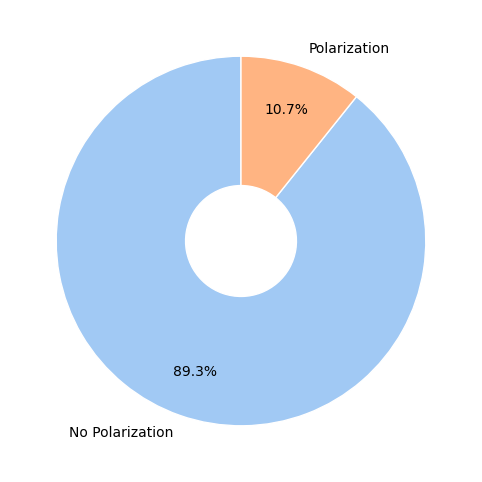

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming 'labels' is already defined as labels = train_initial['polarization'].tolist()

# 1. Count the values
label_counts = Counter(labels)

# Convert to a pandas Series for easier handling and renaming, similar to previous plots
data_counts = pd.Series(label_counts).rename({1: 'Polarization', 0: 'No Polarization'})

# 2. Configuration de la figure
plt.figure(figsize=(8, 6))
#plt.title('Polarization distribution (Hausa)')

# 3. Création du Donut Chart
plt.pie(data_counts,
        labels=data_counts.index,
        colors=sns.color_palette('pastel'),
        autopct='%.1f%%',       # Affiche uniquement le %
        startangle=90,
        pctdistance=0.75,       # Ajuste la position du texte % (plus centré dans la matière)
        wedgeprops={'width': 0.7, 'edgecolor': 'white'})
plt.savefig('subtask1_distribution_haussa.pdf')

plt.show()

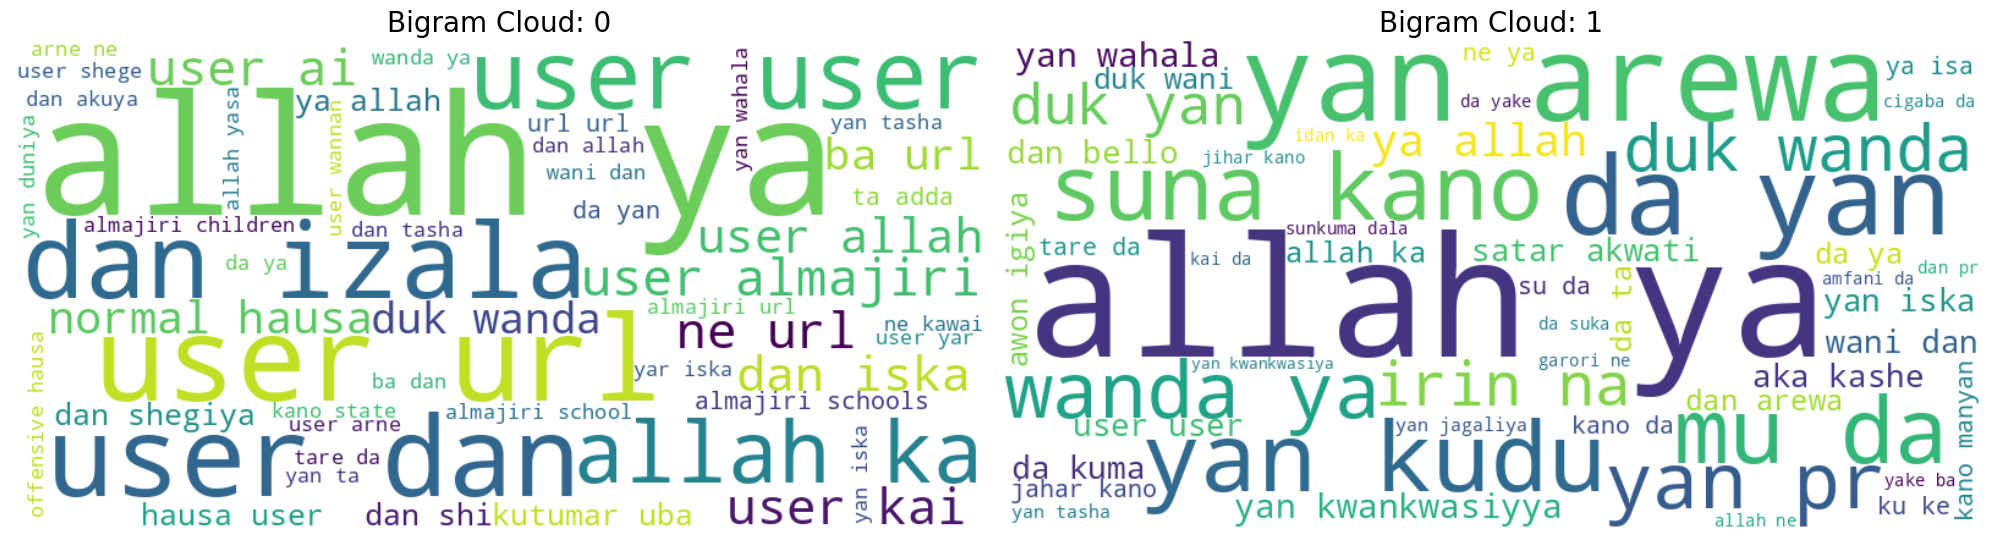

In [ ]:
unique_labels = np.unique(labels)
fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 10))


for i, label in enumerate(unique_labels):

    subset_text = pd.Series(texts)[labels == label] # Convert texts to Series for boolean indexing


    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=50)
    matrix = vectorizer.fit_transform(subset_text.astype(str))


    frequencies = sum(matrix).toarray()[0]
    bg_freq = pd.DataFrame(frequencies, index=vectorizer.get_feature_names_out(), columns=['frequency'])

    freq_dict = bg_freq['frequency'].to_dict()

    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

    ax = axes[i] if len(unique_labels) > 1 else axes
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Bigram Cloud: {label}", fontsize=20)
plt.savefig('lexical_polarization_signalisation_substack1_haussa.pdf')
plt.tight_layout()
plt.show()

### Data split

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split # Import train_test_split

# Re-split data to ensure X_train and X_val are lists of strings
# Assuming 'texts' and 'y' are available from previous executed cells.
test_size = 0.1         # fraction for test set (change if you want)
random_state = 42       # reproducibility
X_train, X_val, Y_train, Y_val = train_test_split(
    texts, labels, test_size=test_size, stratify=labels, random_state=random_state
)


### Tokenisation and data polarisatiion

In [ ]:
import wandb

In [ ]:
MODEL_NAME = "Davlan/afro-xlmr-small"

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Create datasets
train_dataset = PolarizationDataset(tokenizer,X_train, Y_train)
val_dataset = PolarizationDataset(tokenizer,X_val, Y_val)

In [ ]:
wandb.login()
wandb.init(project="polarization-classification", name="bert-large-uncased-fp16",entity="paderborn-university")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: eliasse (paderborn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### function TO Compute differebte metric

In [ ]:
from google.colab import drive
import numpy as np
from sklearn.metrics import f1_score
from transformers import TrainingArguments



def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/afro_small_polarization_best_model",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=32,
    gradient_checkpointing=True,
    fp16=True,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=1,
    logging_steps=1,
    logging_dir="./logs",
    report_to=["wandb"],
    dataloader_num_workers=2
)

In [ ]:
from google.colab import drive
import numpy as np
from sklearn.metrics import f1_score
from transformers import TrainingArguments
import torch

# Vérification et configuration GPU
print("🔍 Vérification du GPU...")
if torch.cuda.is_available():
    print(f"✅ GPU détecté: {torch.cuda.get_device_name(0)}")
    print(f"💾 Mémoire GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device("cuda")
else:
    print("⚠️ Aucun GPU détecté! Le modèle utilisera le CPU (très lent)")
    print("💡 Dans Colab: Runtime > Change runtime type > Hardware accelerator > GPU")
    device = torch.device("cpu")

# Monte Google Drive (à exécuter une seule fois)
drive.mount('/content/drive')

def compute_metrics(p):
    """Calcule la métrique F1 macro pour l'évaluation"""
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/afro_small_polarization_best_model",  # Correction: MyDrive sans espace
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=32,  # Batch size effectif = 2 * 32 = 64
    gradient_checkpointing=True,
    fp16=True,  # Utilise mixed precision (bon pour GPU)
    per_device_eval_batch_size=4,
    eval_strategy="epoch",  # Évalue à chaque epoch
    save_strategy="epoch",  # Sauvegarde à chaque epoch
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,  # AJOUT IMPORTANT: spécifie que F1 plus élevé = meilleur
    save_total_limit=1,  # Garde seulement le meilleur modèle
    logging_steps=10,  # MODIFIÉ: logging_steps=1 peut être trop verbeux
    logging_dir="./logs",
    report_to=["wandb"],  # Assurez-vous d'avoir wandb installé et configuré
    dataloader_num_workers=2,
    # AJOUTS RECOMMANDÉS:
    warmup_ratio=0.1,  # Warmup pour stabiliser l'entraînement
    weight_decay=0.01,  # Régularisation
    push_to_hub=False,  # Explicitement False si vous ne voulez pas push sur HF Hub
)


🔍 Vérification du GPU...
✅ GPU détecté: Tesla T4
💾 Mémoire GPU disponible: 15.83 GB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification, Trainer
from transformers import TrainerCallback
import torch
import wandb

# Redefine WandbBatchLoggerCallback here to ensure it's available
class WandbBatchLoggerCallback(TrainerCallback):
    def on_step_end(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            wandb.log({
                "step": state.global_step,
                "loss": logs.get("loss"),
                "learning_rate": logs.get("learning_rate")
            })

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer),
    callbacks=[WandbBatchLoggerCallback]
)

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

trainer.train()


eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")


wandb.finish()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.275700,0.272999,0.471861
2,0.196300,0.238097,0.830556
3,0.221300,0.231308,0.830556


Macro F1 score on validation set: 0.8305555555555555


eval/f1_macro,▁███
eval/loss,█▂▁▂
eval/runtime,▅▁▄█
eval/samples_per_second,▄█▄▁
eval/steps_per_second,▄█▄▁
train/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇████
train/grad_norm,█▆▂▃▂▁▄▂▄▃▄▃▅▂▁
train/learning_rate,▅█▇▇▆▆▅▅▄▄▃▃▂▂▁
train/loss,█▃▄▂▂▂▂▁▂▁▁▁▁▁▂
eval/f1_macro,0.83056


best performance obtain

In [ ]:
test= pd.read_csv('subtask1/dev/hau.csv')

In [ ]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# 1. Config Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 2. Trouver le chemin du modèle (Checkpoint detection)
base_path = "/content/drive/MyDrive/afro_small_polarization_best_model"
model_path = base_path
if os.path.exists(base_path):
    subfolders = [f.path for f in os.scandir(base_path) if f.is_dir() and "checkpoint" in f.name]
    if subfolders:
        subfolders.sort()
        model_path = subfolders[-1]
        print(f"Checkpoint found: {model_path}")
    else:
        print(f"Using base path: {model_path}")

# 3. Charger Tokenizer et Modèle
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# --- CORRECTION CRITIQUE ICI ---
# 4. Définir une classe Dataset QUI NE LIT PAS LES LABELS
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        # On ne demande pas de labels ici, juste le texte
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False, # Le DataCollator fera le padding dynamique plus tard
            max_length=self.max_len
        )
        return {

            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }

test_dataset = InferenceDataset(test['text'].tolist(), tokenizer)

inference_collator = DataCollatorWithPadding(tokenizer=tokenizer)
loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=inference_collator)


all_preds = []
with torch.no_grad():
    for batch in tqdm(loader, desc="Predicting"):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())

# 7. Sauvegarde
submission_df = pd.DataFrame({
    'id': test['id'],
    'polarization': all_preds
})

submission_file = "pred_hau.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Submission file saved: {submission_file}")

Checkpoint found: /content/drive/MyDrive/afro_small_polarization_best_model/checkpoint-104


Predicting: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]

Submission file saved: pred_hau.csv


## OPtimisation haoussa langue

In [ ]:
from google.colab import drive
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import (
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from transformers import TrainerCallback
import torch
import torch.nn as nn
import wandb
from sklearn.utils.class_weight import compute_class_weight

# ============================================================================
# CONFIGURATION GPU ET DRIVE
# ============================================================================
print("🔍 Vérification du GPU...")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Mémoire: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ GPU non détecté!")

drive.mount('/content/drive')


class FocalLoss(nn.Module):
    """
    Focal Loss pour déséquilibre extrême
    Classe 0 (No/Non-polarisé): 89.3%
    Classe 1 (Yes/Polarisé): 10.7% ← CLASSE MINORITAIRE CRITIQUE
    """
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Poids pour classe minoritaire
        self.gamma = gamma  # Focus sur exemples difficiles
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        # Alpha weighting: plus de poids sur classe 1 (minoritaire)
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)

        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class FocalLossTrainer(Trainer):
    def __init__(self, *args, focal_loss=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss = focal_loss

    # MODIFICATION: Add num_items_in_batch to the signature
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.focal_loss is not None:
            loss = self.focal_loss(logits, labels)
        else:
            loss = outputs.loss

        return (loss, outputs) if return_outputs else loss


def compute_metrics(p):
    """
    Calcule F1 macro + métriques par classe
    Classe 0 = No (89.3%)
    Classe 1 = Yes/Polarisé (10.7% - MINORITAIRE)
    """
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    f1_macro = f1_score(labels, preds, average='macro')
    f1_weighted = f1_score(labels, preds, average='weighted')
    f1_per_class = f1_score(labels, preds, average=None)

    return {
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_class_0_no': f1_per_class[0],  # No: 89.3%
        'f1_class_1_yes_minority': f1_per_class[1],  # Yes: 10.7% ← CRITIQUE
        'accuracy': (preds == labels).mean()
    }

class WandbBatchLoggerCallback(TrainerCallback):
    def on_step_end(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            wandb.log({
                "step": state.global_step,
                "loss": logs.get("loss"),
                "learning_rate": logs.get("learning_rate")
            })

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            wandb.log({
                "eval_f1_macro": metrics.get("eval_f1_macro"),
                "eval_f1_class_0_no": metrics.get("eval_f1_class_0_no"),
                "eval_f1_class_1_yes": metrics.get("eval_f1_class_1_yes_minority"),
            })

MODEL_NAME = "Davlan/afro-xlmr-large"

print(f"📦 Chargement du modèle: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


print("\n📊 DISTRIBUTION DES CLASSES:")
print(f"   Classe 0 (No/Non-polarisé): 89.3% - MAJORITAIRE")
print(f"   Classe 1 (Yes/Polarisé):    10.7% - MINORITAIRE CRITIQUE ⚠️")

# Option 1: Si vous avez train_dataset
def compute_class_weights_from_dataset(train_dataset):
    labels = np.array([example['label'] for example in train_dataset])
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    return torch.tensor(class_weights, dtype=torch.float)

class_weights = torch.tensor([
    1.0 / 0.893,  # Poids classe 0 (No - majoritaire)
    1.0 / 0.107   # Poids classe 1 (Yes - minoritaire) ← BEAUCOUP PLUS ÉLEVÉ
], dtype=torch.float)
class_weights = class_weights / class_weights.sum() * 2

print(f"\n⚖️ POIDS CALCULÉS:")
print(f"   Classe 0 (No):  {class_weights[0]:.2f}")
print(f"   Classe 1 (Yes): {class_weights[1]:.2f} ← Ratio {class_weights[1]/class_weights[0]:.1f}x plus élevé")


# Alpha plus élevé pour compenser le déséquilibre extrême
focal_loss = FocalLoss(
    alpha=0.85,  # Beaucoup de poids sur classe minoritaire (10.7%)
    gamma=3.0    # Gamma élevé pour focus maximal sur exemples difficiles
)

print(f"\n🎯 FOCAL LOSS configurée:")
print(f"   Alpha: 0.85 (85% du poids sur classe minoritaire)")
print(f"   Gamma: 3.0 (focus fort sur exemples mal classés)")

# ===
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/hausa_polarization_afro_xlmr_extreme_imbalance",

    # HYPERPARAMÈTRES OPTIMISÉS
    num_train_epochs=8,  # Plus d'epochs pour apprendre classe rare
    learning_rate=1e-5,  # LR plus faible pour stabilité
    per_device_train_batch_size=2,
    gradient_accumulation_steps=32,  # Batch effectif = 64

    # OPTIMISATIONS MÉMOIRE
    gradient_checkpointing=True,
    fp16=True,
    optim="adamw_torch_fused",


    per_device_eval_batch_size=4,
    eval_strategy="steps",
    eval_steps=50,  # Évalue toutes les 50 steps
    save_strategy="steps",
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_class_1_yes_minority",  # ← OPTIMISE POUR CLASSE RARE !
    greater_is_better=True,
    save_total_limit=3,

    # RÉGULARISATION FORTE
    warmup_ratio=0.2,  # Warmup long pour stabilité
    weight_decay=0.01,
    max_grad_norm=1.0,

    # LEARNING RATE SCHEDULER
    lr_scheduler_type="cosine_with_restarts",  # Avec restarts pour échapper minima locaux

    # LOGGING
    logging_steps=25,
    logging_dir="./logs",
    report_to=["wandb"],
    dataloader_num_workers=2,

    # AUTRES
    seed=42,
    data_seed=42,
)

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        hidden_dropout_prob=0.35,  # Dropout très élevé contre overfitting
        attention_probs_dropout_prob=0.35,
        classifier_dropout=0.4,  # Encore plus sur classifier
        ignore_mismatched_sizes=True
    )
    return model


trainer = FocalLossTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer),
    focal_loss=focal_loss,
    callbacks=[
        WandbBatchLoggerCallback(),
        EarlyStoppingCallback(early_stopping_patience=5)
    ]
)


print("\n" + "="*70)
print("🚀 DÉBUT DE L'ENTRAÎNEMENT")
print("="*70)
print(f"📊 Classe 0 (No):  89.3%")
print(f"📊 Classe 1 (Yes): 10.7% ← CLASSE CIBLE CRITIQUE")
print(f"🎯 Objectif: F1 Macro > 0.90")
print(f"🎯 Focus: Maximiser F1 de la classe 1 (Yes/Polarisé)")
print("="*70 + "\n")

trainer.train()

print("\n" + "="*70)
print("📊 ÉVALUATION FINALE SUR VALIDATION SET")
print("="*70)

eval_results = trainer.evaluate()
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")

# Prédictions détaillées
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\n📋 RAPPORT DE CLASSIFICATION DÉTAILLÉ:")
print(classification_report(
    labels,
    preds,
    target_names=['Classe 0: No/Non-polarisé (89.3%)', 'Classe 1: Yes/Polarisé (10.7% - MINORITAIRE)'],
    digits=4
))

print("\n🎯 MATRICE DE CONFUSION:")
cm = confusion_matrix(labels, preds)
print(f"                    Prédictions →")
print(f"Vraies ↓            | Classe 0 (No) | Classe 1 (Yes)")
print(f"Classe 0 (No)       |   {cm[0,0]:6d}      |   {cm[0,1]:6d}")
print(f"Classe 1 (Yes) ⚠️   |   {cm[1,0]:6d}      |   {cm[1,1]:6d}  ← CRITIQUE")

total_pred_0 = cm[0,0] + cm[1,0]
total_pred_1 = cm[0,1] + cm[1,1]
print(f"\n📊 Distribution des prédictions:")
print(f"   Prédit No:  {total_pred_0} ({100*total_pred_0/(total_pred_0+total_pred_1):.1f}%)")
print(f"   Prédit Yes: {total_pred_1} ({100*total_pred_1/(total_pred_0+total_pred_1):.1f}%)")

print("\n" + "="*70)
print("🔧 RECHERCHE DU SEUIL OPTIMAL DE CLASSIFICATION")
print("="*70)

probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
probs_class_1 = probs[:, 1]

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(labels, probs_class_1)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"🎯 Seuil par défaut: 0.5000 → F1 Macro: {eval_results['eval_f1_macro']:.4f}")
print(f"✨ Seuil optimal:    {optimal_threshold:.4f}")

preds_optimal = (probs_class_1 >= optimal_threshold).astype(int)
f1_macro_optimal = f1_score(labels, preds_optimal, average='macro')
f1_class1_optimal = f1_score(labels, preds_optimal, average=None)[1]

print(f"   F1 Macro avec seuil optimal: {f1_macro_optimal:.4f}")
print(f"   F1 Classe 1 (Yes) avec seuil optimal: {f1_class1_optimal:.4f}")
print(f"📈 Amélioration F1 Macro: +{(f1_macro_optimal - eval_results['eval_f1_macro'])*100:.2f}%")


print("\n💾 Sauvegarde du modèle et du seuil optimal...")
trainer.save_model("/content/drive/MyDrive/hausa_polarization_final_model")
tokenizer.save_pretrained("/content/drive/MyDrive/hausa_polarization_final_model")

import json
with open("/content/drive/MyDrive/hausa_polarization_final_model/optimal_threshold.json", "w") as f:
    json.dump({
        "optimal_threshold": float(optimal_threshold),
        "class_distribution": {"class_0_no": 0.893, "class_1_yes": 0.107},
        "f1_macro_optimal": float(f1_macro_optimal)
    }, f, indent=2)

print(f"✅ Modèle sauvegardé avec seuil optimal: {optimal_threshold:.4f}")

wandb.finish()


print("\n" + "="*70)
print("🔍 DIAGNOSTIC FINAL")
print("="*70)

if f1_macro_optimal >= 0.90:
    print(f"🎉 OBJECTIF ATTEINT! F1 Macro = {f1_macro_optimal:.4f} >= 0.90")
else:
    print(f"📊 F1 Macro actuel: {f1_macro_optimal:.4f}")
    print(f"🎯 Écart à l'objectif: {(0.90 - f1_macro_optimal)*100:.2f}%")
    print("\n💡 STRATÉGIES AVANCÉES À ESSAYER:")
    print("\n1. 🔧 AJUSTER FOCAL LOSS:")
    print("   - Augmenter alpha à 0.90-0.95 (plus de poids sur classe 1)")
    print("   - Augmenter gamma à 3.5-4.0 (focus encore plus fort)")
    print("\n2. 🔄 AUGMENTATION DE DONNÉES:")
    print("   - Back-translation Hausa → Anglais → Hausa")
    print("   - Oversampling de la classe 1 (dupliquer x3-x5)")
    print("   - SMOTE sur embeddings textuels")
    print("\n3. 📊 AJUSTER LE SEUIL:")
    print(f"   - Seuil actuel: {optimal_threshold:.4f}")
    print("   - Essayer seuils: 0.3, 0.35, 0.4, 0.45")
    print("\n4. 🎯 DEUX MODÈLES SÉPARÉS:")
    print("   - Modèle 1: Optimisé pour classe 0 (No)")
    print("   - Modèle 2: Optimisé pour classe 1 (Yes)")
    print("   - Combiner avec seuil adaptatif")
    print("\n5. 🔀 ENSEMBLE DE MODÈLES:")
    print("   - afro-xlmr-large + afro-xlmr-base + xlm-roberta-large")
    print("   - Vote majoritaire pondéré")

print("\n" + "="*70)

🔍 Vérification du GPU...
✅ GPU: Tesla T4
💾 Mémoire: 15.83 GB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Chargement du modèle: Davlan/afro-xlmr-large

📊 DISTRIBUTION DES CLASSES:
   Classe 0 (No/Non-polarisé): 89.3% - MAJORITAIRE
   Classe 1 (Yes/Polarisé):    10.7% - MINORITAIRE CRITIQUE ⚠️

⚖️ POIDS CALCULÉS:
   Classe 0 (No):  0.21
   Classe 1 (Yes): 1.79 ← Ratio 8.3x plus élevé

🎯 FOCAL LOSS configurée:
   Alpha: 0.85 (85% du poids sur classe minoritaire)
   Gamma: 3.0 (focus fort sur exemples mal classés)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 DÉBUT DE L'ENTRAÎNEMENT
📊 Classe 0 (No):  89.3%
📊 Classe 1 (Yes): 10.7% ← CLASSE CIBLE CRITIQUE
🎯 Objectif: F1 Macro > 0.90
🎯 Focus: Maximiser F1 de la classe 1 (Yes/Polarisé)



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1 Macro,F1 Weighted,F1 Class 0 No,F1 Class 1 Yes Minority,Accuracy
50,0.035000,0.022013,0.348508,0.487175,0.524731,0.172285,0.396175
100,0.029800,0.022366,0.310555,0.396527,0.419811,0.201299,0.327869
150,0.030400,0.019343,0.547611,0.766450,0.825719,0.269504,0.718579
200,0.027800,0.018734,0.499034,0.699366,0.753623,0.244444,0.628415
250,0.027900,0.018967,0.461341,0.647794,0.698292,0.224390,0.565574
300,0.028400,0.018284,0.536930,0.759940,0.820339,0.253521,0.710383
350,0.028500,0.018577,0.522887,0.727016,0.782301,0.263473,0.663934
400,0.029100,0.018313,0.554370,0.777604,0.838063,0.270677,0.734973



📊 ÉVALUATION FINALE SUR VALIDATION SET


  eval_loss: 0.0183
  eval_f1_macro: 0.5544
  eval_f1_weighted: 0.7776
  eval_f1_class_0_no: 0.8381
  eval_f1_class_1_yes_minority: 0.2707
  eval_accuracy: 0.7350
  eval_runtime: 10.3503
  eval_samples_per_second: 35.3610
  eval_steps_per_second: 8.8890
  epoch: 8.0000

📋 RAPPORT DE CLASSIFICATION DÉTAILLÉ:
                                              precision    recall  f1-score   support

           Classe 0: No/Non-polarisé (89.3%)     0.9228    0.7676    0.8381       327
Classe 1: Yes/Polarisé (10.7% - MINORITAIRE)     0.1915    0.4615    0.2707        39

                                    accuracy                         0.7350       366
                                   macro avg     0.5571    0.6146    0.5544       366
                                weighted avg     0.8449    0.7350    0.7776       366


🎯 MATRICE DE CONFUSION:
                    Prédictions →
Vraies ↓            | Classe 0 (No) | Classe 1 (Yes)
Classe 0 (No)       |      251      |       76
Classe 1 (Yes

eval/accuracy,▂▁█▆▅█▇██
eval/f1_class_0_no,▃▁█▇▆█▇██
eval/f1_class_1_yes_minority,▁▃█▆▅▇▇██
eval/f1_macro,▂▁█▆▅▇▇██
eval/f1_weighted,▃▁█▇▆█▇██
eval/loss,▇█▃▂▂▁▂▁▁
eval/runtime,▁▁▂▁▂▂▁▁█
eval/samples_per_second,██▆█▇▇██▁
eval/steps_per_second,██▆█▇▇██▁
eval_f1_class_0_no,▃▁█▇▆█▇██
+16,...



🔍 DIAGNOSTIC FINAL
📊 F1 Macro actuel: 0.6152
🎯 Écart à l'objectif: 28.48%

💡 STRATÉGIES AVANCÉES À ESSAYER:

1. 🔧 AJUSTER FOCAL LOSS:
   - Augmenter alpha à 0.90-0.95 (plus de poids sur classe 1)
   - Augmenter gamma à 3.5-4.0 (focus encore plus fort)

2. 🔄 AUGMENTATION DE DONNÉES:
   - Back-translation Hausa → Anglais → Hausa
   - Oversampling de la classe 1 (dupliquer x3-x5)
   - SMOTE sur embeddings textuels

3. 📊 AJUSTER LE SEUIL:
   - Seuil actuel: 0.5316
   - Essayer seuils: 0.3, 0.35, 0.4, 0.45

4. 🎯 DEUX MODÈLES SÉPARÉS:
   - Modèle 1: Optimisé pour classe 0 (No)
   - Modèle 2: Optimisé pour classe 1 (Yes)
   - Combiner avec seuil adaptatif

5. 🔀 ENSEMBLE DE MODÈLES:
   - afro-xlmr-large + afro-xlmr-base + xlm-roberta-large
   - Vote majoritaire pondéré



In [ ]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# 1. Config Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 2. Trouver le chemin du modèle (Checkpoint detection)
base_path = "/content/drive/MyDrive/hausa_polarization_afro_xlmr_extreme_imbalance"
model_path = base_path
if os.path.exists(base_path):
    subfolders = [f.path for f in os.scandir(base_path) if f.is_dir() and "checkpoint" in f.name]
    if subfolders:
        subfolders.sort()
        model_path = subfolders[-1]
        print(f"Checkpoint found: {model_path}")
    else:
        print(f"Using base path: {model_path}")

# 3. Charger Tokenizer et Modèle
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# --- CORRECTION CRITIQUE ICI ---
# 4. Définir une classe Dataset QUI NE LIT PAS LES LABELS
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        # On ne demande pas de labels ici, juste le texte
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False, # Le DataCollator fera le padding dynamique plus tard
            max_length=self.max_len
        )
        return {

            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }

test_dataset = InferenceDataset(test['text'].tolist(), tokenizer)

inference_collator = DataCollatorWithPadding(tokenizer=tokenizer)
loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=inference_collator)


all_preds = []
with torch.no_grad():
    for batch in tqdm(loader, desc="Predicting"):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())

# 7. Sauvegarde
submission_df = pd.DataFrame({
    'id': test['id'],
    'polarization': all_preds
})

submission_file = "pred_hau.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Submission file saved: {submission_file}")

Checkpoint found: /content/drive/MyDrive/hausa_polarization_afro_xlmr_extreme_imbalance/checkpoint-416


The tokenizer you are loading from '/content/drive/MyDrive/hausa_polarization_afro_xlmr_extreme_imbalance/checkpoint-416' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Predicting: 100%|██████████| 6/6 [00:02<00:00,  2.02it/s]

Submission file saved: pred_hau.csv
